In [1]:
import bagpy
from bagpy import bagreader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import copy

plt.rcParams['text.usetex'] = True

def find_closest_values(s, x):
    idx = (np.abs(s - x)).argmin()
    return idx
    
def crop_df_time(df, start_time, end_time):
    start_index = find_closest_values(df['Time'], start_time)
    end_index = find_closest_values(df['Time'], end_time)
    new_df = df[start_index:end_index]
    new_df = new_df.reset_index()
    return new_df

def upsample_dataframes(df1, df2):
    # Check which dataframe has fewer measurements
    if len(df1) < len(df2):
        shorter_df, longer_df = df1, df2
    else:
        shorter_df, longer_df = df2, df1

    # Calculate the ratio for upsampling
    ratio = len(longer_df) // len(shorter_df)

    # Upsample the shorter dataframe to match the length of the longer dataframe
    upsampled_shorter_df = pd.concat([shorter_df] * ratio, ignore_index=True)

    # Trim the longer dataframe to match the length of the shorter dataframe
    trimmed_longer_df = longer_df.iloc[:len(upsampled_shorter_df)]

    return trimmed_longer_df, upsampled_shorter_df

def scale_time(df): 
    
    df_ = copy.deepcopy(df)
    df_['Time'] = df['Time'] - df['Time'][0]
    return df_

def plot_position(pandas_odometry): 
    t = pandas_odometry['Time']
    x = pandas_odometry['pose.pose.position.x']
    y = pandas_odometry['pose.pose.position.y']
    z = pandas_odometry['pose.pose.position.z']
    
    plt.figure(figsize=(14, 5))

    # Plot positions over time
    plt.plot(t, x, label='X Position', color='red')
    plt.plot(t, y, label='Y Position', color='green')
    plt.plot(t, z, label='Z Position', color='blue')

    # Set axis labels and a title
    plt.xlabel('Time (t)')
    plt.ylabel('Position[m]')
    plt.title('Position')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    
def get_relative_position(odom1, odom2): 
    
    t1 = odom1['Time']; t2 = odom2['Time']
    len_t1 = len(t1); len_t2 = len(t2)
    
    if len(t1) > len(t2): 
        len_t1 = len(t2)
    else: 
        len_t2 = len(t1)
        
    print(len_t1)
    print(len_t2)
        
    x1 = odom1['pose.pose.position.x'][:len_t1]
    y1 = odom1['pose.pose.position.y'][:len_t1]
    z1 = odom1['pose.pose.position.z'][:len_t1]
    
    x2 = odom2['pose.pose.position.x'][:len_t2]
    y2 = odom2['pose.pose.position.y'][:len_t2]
    z2 = odom2['pose.pose.position.z'][:len_t2]
    t1 = t1[:len_t1]
    t2 = t2[:len_t2]
    
    t = t1
    x = x1-x2
    y = y1-y2
    z = z1-z2 
    
    return t,x,y,z

def extract_positions(odom1, not_scale=None): 
    
    if not_scale:
        pass
    else:
        odom1 = scale_time(odom1)
    t = odom1['Time']
    x = odom1['pose.pose.position.x']
    y = odom1['pose.pose.position.y']
    z = odom1['pose.pose.position.z']
    return t, x, y, z

def extract_ref(pose, not_scale=None):
    if not_scale:
        pass
    else:
        pose = scale_time(pose)
    t = pose['Time']
    x = pose['pose.position.x']
    y = pose['pose.position.y']
    z = pose['pose.position.z']
    return t,x,y,z

def extract_vel_ref(data, not_scale=None): 
    data = scale_time(data)
    t = data['Time']
    x = data['x']
    y = data['y']
    z = data['z']
    return extract_vel_ref

def extract_velocities(odom1, not_scale=None):
    
    odom1 = scale_time(odom1)
    t = odom1['Time']
    vx = odom1['twist.twist.linear.x']
    vy = odom1['twist.twist.linear.y']
    vz = odom1['twist.twist.linear.z']
    return t, vx, vy, vz

def extract_orientations(odom, not_scale=None): 
    
    if not_scale:
        pass
    else:
        odom = scale_time(odom)
    qx = odom['pose.pose.orientation.x']
    qy = odom['pose.pose.orientation.y']
    qz = odom['pose.pose.orientation.z']
    qw = odom['pose.pose.orientation.w']
    
    
def plot_relative_position(t, x, y, z): 
    
    plt.figure(figsize=(10, 6))

    # Plot positions over time
    plt.plot(t, x, label='X Position', linestyle='-')
    plt.plot(t, y, label='Y Position', linestyle='-')#, marker='s')
    plt.plot(t, z, label='Z Position', linestyle='-')#, marker='^')

    # Set axis labels and a title
    plt.xlabel('Time (t)')
    plt.ylabel('Position')
    plt.title('Positions Over Time')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    
def plot_trajectories(x1, y1, z1, x2, y2, z2, fig_w=15, fig_h=15):
    """
    Plots a trajectory in 3D space.

    Parameters:
    - x_coords (list): List of x-coordinates.
    - y_coords (list): List of y-coordinates.
    - z_coords (list): List of z-coordinates.

    Returns:
    - None
    """
    # Create a 3D figure
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the trajectory as a 3D line
    ax.plot(x1, y1, z1, label='UAV trajectory', linewidth=1, color='blue')
    ax.plot(x2, y2, z2, label='Net trajectory', linewidth=1, color='red', linestyle='--')

    # Set labels for the axes
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()    
    
    fig.savefig('3d_trajectory.svg')
    
def plot_positions(t1, x1, y1, z1, t2, x2, y2, z2, name="Position", title=None):
    """
    Plot positions of two objects over time in a subplot with two subplots (one below the other).

    Parameters:
    - object1_positions: List or NumPy array of positions for object 1 over time.
    - object2_positions: List or NumPy array of positions for object 2 over time.
    - time_values: List or NumPy array of time values.

    Returns:
    - None (displays the plot).
    """
    if len(t1) != len(t2):
        x1, x2 = upsample_dataframes(x1, x2)
        y1, y2 = upsample_dataframes(y1, y2)
        z1, z2 = upsample_dataframes(z1, z2)
        t1, t2 = upsample_dataframes(t1, t2)

    # Create a 2x1 subplot grid
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

    # Plot object 1 positions
    ax1.plot(t1, x1, label='x_uav', color='red')
    ax1.plot(t2, x2, label='x_net', color='red', linestyle='--')
    ax1.set_ylabel('x[m]')
    ax1.grid()
    ax1.legend()

    # Plot object 2 positions
    ax2.plot(t1, y1, label='y_uav', color='green')
    ax2.plot(t2, y2, label='y_net', color='green', linestyle='--')
    ax2.set_ylabel('y[m]')
    ax2.grid()
    ax2.legend()
    
    ax3.plot(t1, z1, label="z_uav", color='blue')
    ax3.plot(t2, z2, label='z_net', color='blue', linestyle='--')
    ax3.set_ylabel('z[m]')
    ax3.set_xlabel('t[s]')
    ax3.grid()
    ax3.legend()

    # Set a title for the entire subplot
    if title:
        plt.suptitle('Position [m], max_v = {}, max_a = {}'.format(title[0], title[1]))
    else: 
        plt.suptitle('Position [m]')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    fig.savefig('{}.svg'.format(name))
    
    
def plot_positions_full(t, x, y, z, name="Position", title=None):
    """
    Plot positions of two objects over time in a subplot with two subplots (one below the other).

    Parameters:
    - object1_positions: List or NumPy array of positions for object 1 over time.
    - object2_positions: List or NumPy array of positions for object 2 over time.
    - time_values: List or NumPy array of time values.

    Returns:
    - None (displays the plot).
    """
    last_t = 1
    for i, t_ in enumerate(t): 
        if len(t_) > last_t: 
            last_t = len(t_)
            max_i = i
            
    for x_, y_, z_ in zip(x_, y_, z_): 
        x_  = upsample_dataframes(x_, x[max_i])
        y_  = upsample_dataframes(y_, y[max_i])
        z_  = upsample_dataframes(z_, z[max_i])

    # Create a 2x1 subplot grid
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

    # Plot object 1 positions
    ax1.plot(t1, x1, label='x_uav', color='red')
    ax1.plot(t2, x2, label='x_net', color='red', linestyle='--')
    ax1.set_ylabel('x[m]')
    ax1.grid()
    ax1.legend()

    # Plot object 2 positions
    ax2.plot(t1, y1, label='y_uav', color='green')
    ax2.plot(t2, y2, label='y_net', color='green', linestyle='--')
    ax2.set_ylabel('y[m]')
    ax2.grid()
    ax2.legend()
    
    ax3.plot(t1, z1, label="z_uav", color='blue')
    ax3.plot(t2, z2, label='z_net', color='blue', linestyle='--')
    ax3.set_ylabel('z[m]')
    ax3.set_xlabel('t[s]')
    ax3.grid()
    ax3.legend()

    # Set a title for the entire subplot
    if title:
        plt.suptitle('Position [m], max_v = {}, max_a = {}'.format(title[0], title[1]))
    else: 
        plt.suptitle('Position [m]')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    fig.savefig('{}.svg'.format(name))
    
def find_topic_name_and_index(topic_name, csv_files): 
    for i, name in enumerate(csv_files): 
        if topic_name in name: 
            print("index: {}; topic_name: {}".format(i, name))
            return i
            
def find_bag_by_name(name, bag_list): 
    for i, bag_name in enumerate(bag_list): 
        if name in bag_name: 
            if ".bag" in bag_name:
                return i
            
def create_csv(bagreader_object):
    csv_files = []
    for topic in bagreader_object.topics:
        data = bagreader_object.message_by_topic(topic)
        csv_files.append(data)
    return csv_files

def read_bags(bag_folder): 
    for bag_name in os.listdir(bag_folder): 
        bag_paths.append("{}/{}".format(bag_folder, bag_name))
    return bag_paths

/home/zozan/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
bag_paths = []
for bag_name in os.listdir("./bags"):
    bag_paths.append("./bags/{}".format(bag_name))

## Comparison of the fast and slow trajectories

In [15]:
i_slow = find_bag_by_name('slow', bag_paths)
i_middle = find_bag_by_name('middle', bag_paths)
i_fast = find_bag_by_name('fast', bag_paths)

b_slow = bagreader(bag_paths[i_slow])
b_middle = bagreader(bag_paths[i_middle])
b_fast = bagreader(bag_paths[i_fast])

csv_slow = create_csv(b_slow)
csv_middle = create_csv(b_middle)
csv_fast = create_csv(b_fast)

# Slow
uav_slow = pd.read_csv(csv_slow[1]); uav_slow = scale_time(uav_slow)
net_slow = pd.read_csv(csv_slow[4]); net_slow = scale_time(net_slow)

# Mid
uav_mid = pd.read_csv(csv_middle[1]); uav_mid = scale_time(uav_mid)
net_mid = pd.read_csv(csv_middle[4]); net_mid = scale_time(net_mid)

# Fast
uav_fast = pd.read_csv(csv_fast[1]); uav_fast = scale_time(uav_fast)
net_fast = pd.read_csv(csv_fast[4]); net_fast = scale_time(net_fast)

[INFO]  Data folder ./bags/bezier_full_slow already exists. Not creating.
[INFO]  Data folder ./bags/bezier_full_middle already exists. Not creating.
[INFO]  Data folder ./bags/first_fast_pool already exists. Not creating.


# Plot x,y,z on one plot

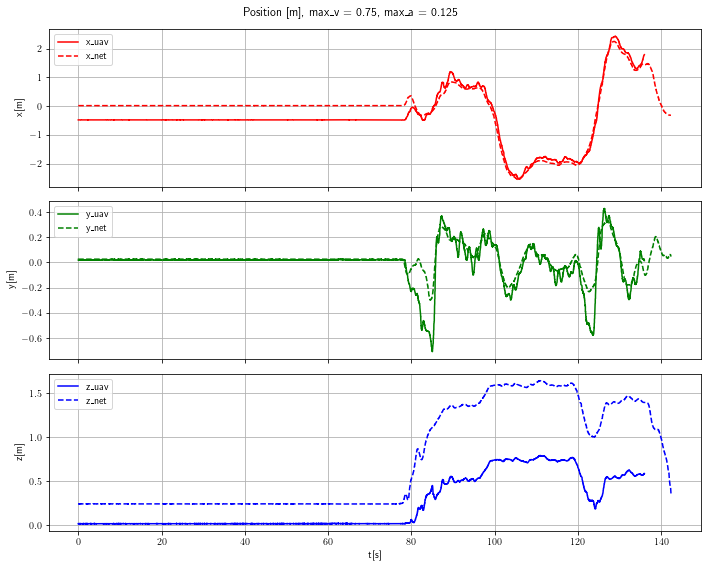

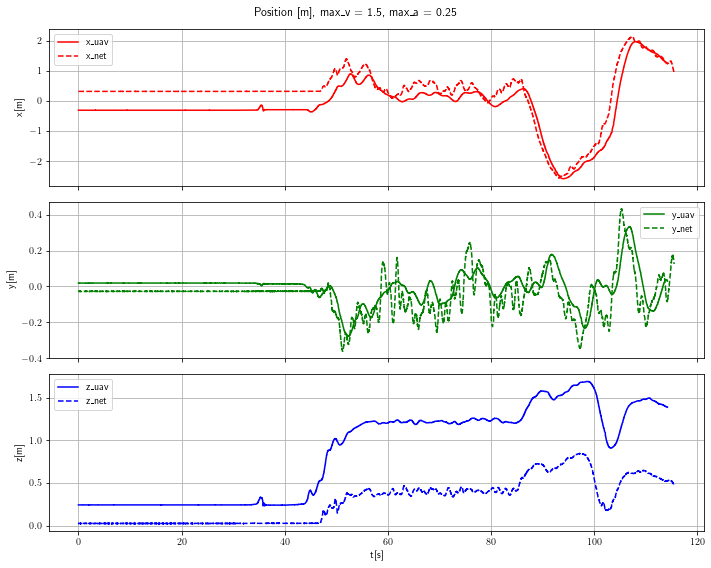

KeyError: 'pose.pose.position.x'

In [16]:
# UAV Slow
# uav_slow = crop_df_time(uav_slow, 120, 135); net_slow = crop_df_time(net_slow, 120, 135)
ts0,xs0,ys0,zs0 = extract_positions(uav_slow)
ts1,xs1,ys1,zs1 = extract_positions(net_slow)
plot_positions(ts0, xs0, ys0, zs0, ts1, xs1, ys1, zs1, title=(0.75, 0.125))

# UAV middle 
#uav_mid = crop_df_time(uav_mid, 120, 1); net_mid = crop_df_time()
tm0,xm0,ym0,zm0 = extract_positions(uav_mid)
tm1,xm1,ym1,zm1 = extract_positions(net_mid)
plot_positions(tm0, xm0, ym0, zm0, tm1, xm1, ym1, zm1, title=(1.5, 0.25))

# UAV fast
#uav_fast = crop_df_time(); net_fast= crop_df_time()

# Breaks for some reason, but wrong bag probably
tf0,xf0,yf0,zf0 = extract_positions(uav_fast)
tf1,xf1,yf1,zf1 = extract_positions(net_fast)
plot_positions(tf0, xf0, yf0, zf0, tf1, xf1, yf1, zf1, title=(1.5, 0.5))

## Plot x,y,z one subplots

In [ ]:
# Create a 2x1 subplot grid
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

# Plot object 1 positions
ax1.plot(ts0, xs0, label='x_us', color='red')
ax1.plot(ts1, xs1, label='x_ns', color='red', linestyle='--')
# Medium 
ax1.plot(tm0, xm0, label='x_um', color='blue')
ax1.plot(tm1, xm1, label='x_nm', color='blue', linestyle='--')
# Fast
ax1.plot(tf0, xf0, label='x_uf', color='green')
ax1.plot(tf1, xf1, label='x_nf', color='green', linestyle='--')

ax1.set_ylabel('x[m]')
ax1.set_xlim(0, 140)
ax1.grid()
ax1.legend(loc='best')

# Plot object 2 positions
ax2.plot(ts0, ys0, label='y_us', color='red')
ax2.plot(ts1, ys1, label='y_ns', color='red', linestyle='--')
# Medium 
ax2.plot(tm0, ym0, label='y_um', color='blue')
ax2.plot(tm1, ym1, label='y_nm', color='blue', linestyle='--')
# Fast
ax2.plot(tf0, yf0, label='y_uf', color='green')
ax2.plot(tf1, yf1, label='y_nf', color='green', linestyle='--')
ax2.set_ylabel('y[m]')
ax2.set_xlim(0, 140)
ax2.grid()
ax2.legend(loc='best')
    
# Plot object 2 positions
ax3.plot(ts0, zs0, label='z_us', color='red')
ax3.plot(ts1, zs1, label='y_ns', color='red', linestyle='--')
# Medium 
ax3.plot(tm0, zm0, label='z_um', color='blue')
ax3.plot(tm1, zm1, label='z_nm', color='blue', linestyle='--')
# Fast
ax3.plot(tf0, zf0, label='z_uf', color='green')
ax3.plot(tf1, zf1, label='z_nf', color='green', linestyle='--')
ax3.set_ylabel('z[m]')
ax3.set_xlim(0, 140)
ax3.grid()
ax3.legend(loc='best')

plt.suptitle('Positions [m]')
plt.savefig('DiffTrackerConstraints.svg')

## Plot 3D trajectory

In [ ]:
plot_trajectories(xm0, ym0, zm0, xm1, ym1, zm1)

## Plot detected poses

In [7]:
topic_name = "net"
find_topic_name_and_index(topic_name, csv_fast)
find_topic_name_and_index('detected_poses', csv_fast)

index: 8; topic_name: ./bags/first_fast_pool/net-vrpn_client-estimated_odometry.csv
index: 9; topic_name: ./bags/first_fast_pool/net-vrpn_client-estimated_transform.csv
index: 10; topic_name: ./bags/first_fast_pool/net-vrpn_client-vicon_intermediate_results.csv
index: 1; topic_name: ./bags/first_fast_pool/detected_poses.csv


## UAV and Net position

In [ ]:
plot_position(uav_pose)
plot_position(net_pose)

In [ ]:
t1,x1,y1,z1 = extract_positions(uav_pose)
t2,x2,y2,z2 = extract_positions(net_pose)
print(len(t1), len(t2))

## UAV and net position subplot

In [ ]:
plot_positions(t1, x1, y1, z1, t2, x2, y2, z2)

In [ ]:
ts0,vxs0,vys0,vzs0 = extract_velocities(uav_slow)
ts1,vxs1,vys1,vzs1 = extract_velocities(net_slow)
plot_positions(ts0, vxs0, vys0, vzs0, ts1, vxs1, vys1, vzs1, title=(0.75, 0.125))

In [ ]:
tm0,xm0,ym0,zm0 = extract_velocities(uav_mid)
tm1,xm1,ym1,zm1 = extract_velocities(net_mid)
plot_positions(tm0, xm0, ym0, zm0, tm1, xm1, ym1, zm1, title=(1.5, 0.25))

In [ ]:
uav_slow = crop_df_time(uav_slow, 120, 135); net_slow = crop_df_time(net_slow, 120, 135)
ts0,xs0,ys0,zs0 = extract_positions(uav_slow)
ts1,xs1,ys1,zs1 = extract_positions(net_slow)

uav_mid = crop_df_time(uav_mid, 95, 115); net_mid = crop_df_time(net_mid, 95, 115)
tm0,xm0,ym0,zm0 = extract_positions(uav_mid)
tm1,xm1,ym1,zm1 = extract_positions(net_mid)

uav_fast = crop_df_time(uav_fast, 100, 125); net_fast= crop_df_time(net_fast, 100, 125)
tf0,xf0,yf0,zf0 = extract_positions(uav_fast)
tf1,xf1,yf1,zf1 = extract_positions(net_fast)

In [ ]:
# Create a 2x1 subplot grid
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

# Plot object 1 positions
ax1.plot(ts0, xs0, label='x_us', color='red')
ax1.plot(ts1, xs1, label='x_ns', color='red', linestyle='--')
# Medium 
ax1.plot(tm0, xm0, label='x_um', color='blue')
ax1.plot(tm1, xm1, label='x_nm', color='blue', linestyle='--')
# Fast
ax1.plot(tf0, xf0, label='x_uf', color='green')
ax1.plot(tf1, xf1, label='x_nf', color='green', linestyle='--')


ax1.set_ylabel('x[m]')
ax1.grid()
ax1.legend()

# Plot object 2 positions
ax2.plot(ts0, ys0, label='y_us', color='red')
ax2.plot(ts1, ys1, label='y_ns', color='red', linestyle='--')
# Medium 
ax2.plot(tm0, ym0, label='y_um', color='blue')
ax2.plot(tm1, ym1, label='y_nm', color='blue', linestyle='--')
# Fast
ax2.plot(tf0, yf0, label='y_uf', color='green')
ax2.plot(tf1, yf1, label='y_nf', color='green', linestyle='--')
ax2.set_ylabel('y[m]')
ax2.grid()
ax2.legend()
    
# Plot object 2 positions
ax3.plot(ts0, zs0, label='z_us', color='red')
ax3.plot(ts1, zs1, label='y_ns', color='red', linestyle='--')
# Medium 
ax3.plot(tm0, zm0, label='z_um', color='blue')
ax3.plot(tm1, zm1, label='z_nm', color='blue', linestyle='--')
# Fast
ax3.plot(tf0, zf0, label='z_uf', color='green')
ax3.plot(tf1, zf1, label='z_nf', color='green', linestyle='--')
ax3.set_ylabel('y[m]')
ax3.grid()
ax3.legend()

plt.suptitle('Positions [m]')

## Transform detected pose into UAV frame


In [45]:
p = np.array([0.425, -0.17, 1.22, 1]).reshape(4, 1)

#x: 0.4251267611980438
#y: -0.16620703041553497
#z: 1.222000002861023


def get_RotX(angle): 
    T = np.array([[1, 0, 0, 0], 
                  [0, np.cos(angle), -np.sin(angle), 0], 
                  [0, np.sin(angle), np.cos(angle), 0], 
                  [0, 0, 0, 1]])
    return T

 
Tx = get_RotX(np.radians(-60))
print(Tx)
T_base_cam = np.array([[0, 0, 1, 0], 
                       [-1, 0, 0, 0], 
                       [0, -1, 0, 0], 
                       [0, 0, 0, 1]])
p = np.matmul(Tx, p)
p = np.matmul(T_base_cam, p)

[[ 1.         0.         0.         0.       ]
 [ 0.         0.5        0.8660254  0.       ]
 [ 0.        -0.8660254  0.5        0.       ]
 [ 0.         0.         0.         1.       ]]
[[0.425     ]
 [0.97155099]
 [0.75722432]
 [1.        ]]
[[ 0.75722432]
 [-0.425     ]
 [-0.97155099]
 [ 1.        ]]


## 3D trajectory plot of the UAV and the Net

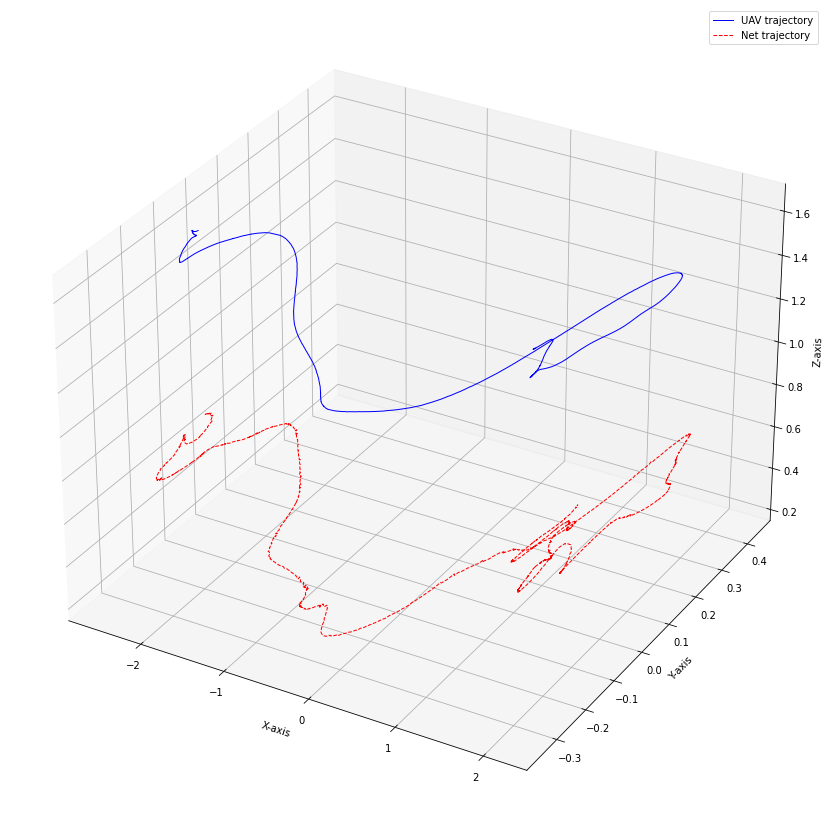

## Debug MPC tracker

In [116]:
i_fast_pool = find_bag_by_name('first_fast_pool', bag_paths) 
bagreader_fast_pool = bagreader(bag_paths[i_fast_pool])
csv_ = create_csv(bagreader_fast_pool)

[INFO]  Data folder ./bags/first_fast_pool already exists. Not creating.


In [27]:
for i in csv_:
    if 'vel' in i:
        print(i)
        
i_carrot = find_topic_name_and_index('carrot-pose', csv_)
i_meas = find_topic_name_and_index('falconsilver', csv_)
i_net = find_topic_name_and_index('net', csv_)
i_vel_ref = find_topic_name_and_index('carrot-velocity', csv_)
i_tracker = find_topic_name_and_index('input_trajectory', csv_)
i_detected_objects = find_topic_name_and_index('detected_objects', csv_)

pose_ref = pd.read_csv(csv_[i_carrot])
pose_meas = pd.read_csv(csv_[i_meas])
pose_net = pd.read_csv(csv_[i_net])
vel_ref = pd.read_csv(csv_[i_vel_ref])
input_trajectory = pd.read_csv(csv_[i_tracker])
detected_poses = pd.read_csv(csv_[i_detected_objects])

vt_m,vx_m, vy_m, vz_m = extract_velocities(pose_meas)
t_r,x_r,y_r,z_r = extract_ref(pose_ref)
t_m,x_m,y_m,z_m = extract_positions(pose_meas)
t_net, x_net, y_net, z_net = extract_positions(pose_net)
pose_meas = scale_time(pose_meas)
vt_r,vx_r, vy_r, vz_r = pose_meas['Time'], pose_meas['twist.twist.linear.x'], pose_meas['twist.twist.linear.y'], pose_meas['twist.twist.linear.z']

./bags/mpc_toppra_compr/red-carrot-velocity.csv
./bags/mpc_toppra_compr/red-uav-velocity.csv
index: 10; topic_name: ./bags/mpc_toppra_compr/red-carrot-pose.csv
index: 2; topic_name: ./bags/mpc_toppra_compr/falconsilver-vrpn_client-estimated_odometry.csv
index: 7; topic_name: ./bags/mpc_toppra_compr/net-vrpn_client-estimated_odometry.csv
index: 13; topic_name: ./bags/mpc_toppra_compr/red-carrot-velocity.csv
index: 47; topic_name: ./bags/mpc_toppra_compr/red-tracker-input_trajectory.csv
index: 0; topic_name: ./bags/mpc_toppra_compr/detected_objects.csv


Text(0.5, 0.98, 'Positions [m]')

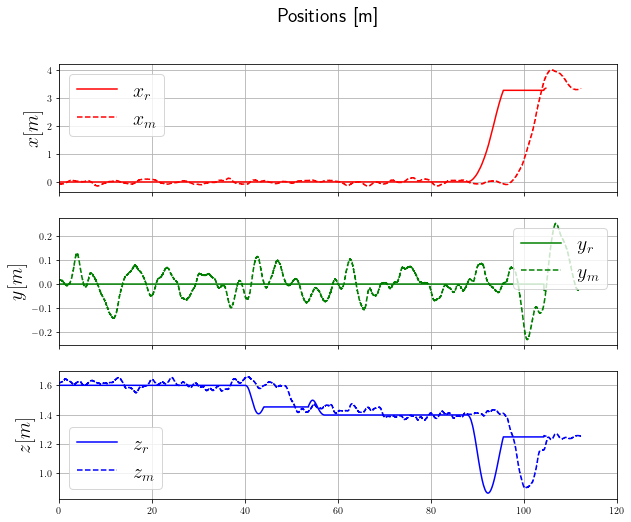

In [28]:
# Figure 
label_size=20
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

offset = 7.5

# Plot object 1 positions
ax1.plot(t_r-offset, x_r, label='$$x_r$$', color='red')
ax1.plot(t_m, x_m, label='$$x_m$$', color='red', linestyle='--')

ax1.set_ylabel('$$x [m]$$', fontsize=label_size)
ax1.grid()
ax1.set_xlim(0, 120)
ax1.legend(fontsize=label_size)

# Plot object 2 positions
ax2.plot(t_r-offset, y_r, label='$$y_r$$', color='green')
ax2.plot(t_m, y_m, label='$$y_m$$', color='green', linestyle='--')

ax2.set_ylabel('$$y [m]$$', fontsize=label_size)
ax2.grid()
ax2.set_xlim(0, 120)
ax2.legend(fontsize=label_size)
    
# Plot object 2 positions
ax3.plot(t_r-offset, z_r, label='$$z_r$$', color='blue')
ax3.plot(t_m, z_m, label='$$z_m$$', color='blue', linestyle='--')

ax3.set_ylabel('$$z [m]$$', fontsize=label_size)
ax3.grid()
ax2.set_xlim(0, 120)
ax3.legend(fontsize=label_size)

plt.suptitle('Positions [m]', fontsize=label_size)

Text(0.5, 0.98, 'Positions [m]')

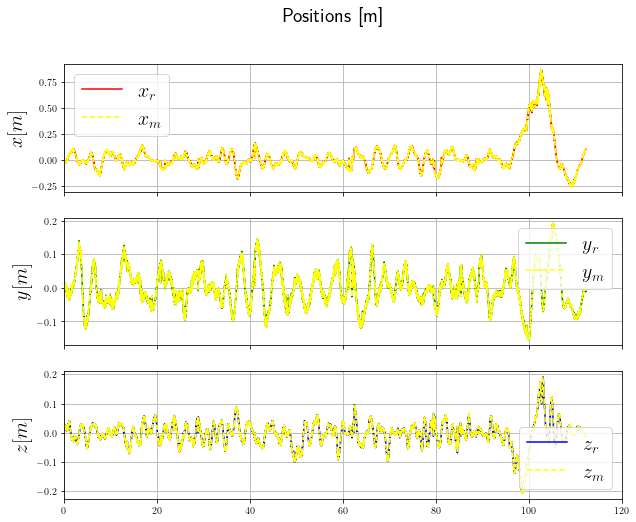

In [29]:
# Figure 
label_size=20
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

# Plot object 1 positions
ax1.plot(vt_r, vx_r, label='$$x_r$$', color='red')
ax1.plot(vt_m, vx_m, label='$$x_m$$', color='yellow', linestyle='--')

ax1.set_ylabel('$$x [m]$$', fontsize=label_size)
ax1.grid()
ax1.set_xlim(0, 120)
ax1.legend(fontsize=label_size)

# Plot object 2 positions
ax2.plot(vt_r, vy_r, label='$$y_r$$', color='green')
ax2.plot(vt_m, vy_m, label='$$y_m$$', color='yellow', linestyle='--')

ax2.set_ylabel('$$y [m]$$', fontsize=label_size)
ax2.grid()
ax2.set_xlim(0, 120)
ax2.legend(fontsize=label_size)
    
# Plot object 2 positions
ax3.plot(vt_r, vz_r, label='$$z_r$$', color='blue')
ax3.plot(vt_m, vz_m, label='$$z_m$$', color='yellow', linestyle='--')

ax3.set_ylabel('$$z [m]$$', fontsize=label_size)
ax3.grid()
ax2.set_xlim(0, 120)
ax3.legend(fontsize=label_size)

plt.suptitle('Positions [m]', fontsize=label_size)

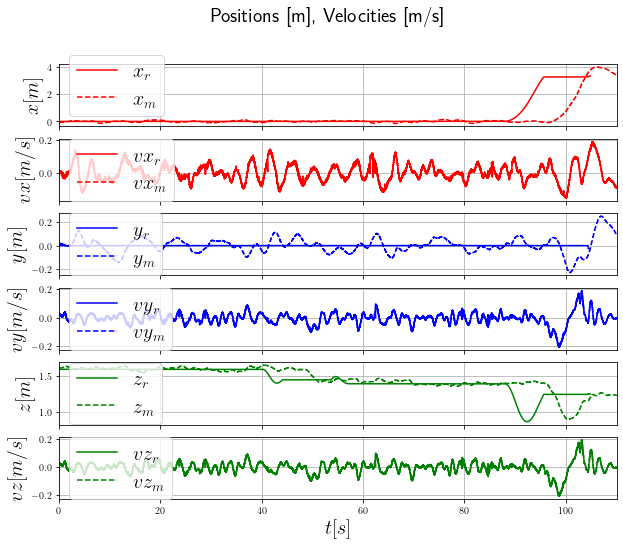

In [30]:
# Figure 
label_size=20
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex=True, figsize=(10, 8))

offset = 7.5
xlim_ = 110

# Plot object 1 positions
ax1.plot(t_r-offset, x_r, label='$$x_r$$', color='red')
ax1.plot(t_m, x_m, label='$$x_m$$', color='red', linestyle='--')
ax1.set_ylabel('$$x [m]$$', fontsize=label_size)
ax1.grid()
ax1.set_xlim(0, xlim_)
ax1.legend(fontsize=label_size)

# Plot object 2 positions
ax2.plot(vt_r, vy_r, label='$$vx_r$$', color='red')
ax2.plot(vt_m, vy_m, label='$$vx_m$$', color='red', linestyle='--')
ax2.set_ylabel('$$vx [m/s]$$', fontsize=label_size)
ax2.grid()
ax2.set_xlim(0, xlim_)
ax2.legend(fontsize=label_size, loc='center left')
    
# Plot object 2 positions
ax3.plot(t_r-offset, y_r, label='$$y_r$$', color='blue')
ax3.plot(t_m, y_m, label='$$y_m$$', color='blue', linestyle='--')
ax3.set_ylabel('$$y [m]$$', fontsize=label_size)
ax3.grid()
ax3.legend(fontsize=label_size, loc='center left')

# Plot object 2 velocities
ax4.plot(vt_r, vz_r, label='$$vy_r$$', color='blue')
ax4.plot(vt_m, vz_m, label='$$vy_m$$', color='blue', linestyle='--')
ax4.set_ylabel('$$vy [m/s]$$', fontsize=label_size)
ax4.grid()
ax4.set_xlim(0, xlim_)
ax4.legend(fontsize=label_size, loc='center left')

# Plot object 2 positions
ax5.plot(t_r-offset, z_r, label='$$z_r$$', color='green')
ax5.plot(t_m, z_m, label='$$z_m$$', color='green', linestyle='--')
ax5.set_ylabel('$$z [m]$$', fontsize=label_size)
ax5.grid()
ax5.set_xlim(0, xlim_)
ax5.legend(fontsize=label_size, loc='center left')

# Plot object 2 positions
ax6.plot(vt_r, vz_r, label='$$vz_r$$', color='green')
ax6.plot(vt_m, vz_m, label='$$vz_m$$', color='green', linestyle='--')
ax6.set_ylabel('$$vz [m/s]$$', fontsize=label_size)
ax6.grid()
ax6.set_xlim(0, xlim_)
ax6.legend(fontsize=label_size, loc='center left')
ax6.set_xlabel('$$t [s]$$', fontsize=label_size)

plt.suptitle('Positions [m], Velocities [m/s]', fontsize=label_size)
plt.savefig('BezVelPos.svg')


In [31]:
import re

def parse_string_for_xyz_values(input_string):
    x_values = []
    y_values = []
    z_values = []

    # Regular expression to match 'x:', 'y:', and 'z:' followed by numerical values
    pattern = r'(x|y|z): (\d+(\.\d+)?)'

    # Find all matches in the input string
    matches = re.findall(pattern, input_string)

    for match in matches:
        label, value_str, _ = match
        value = eval(value_str)
        
        if label == 'x':
            x_values.append(value)
        elif label == 'y':
            y_values.append(value)
        elif label == 'z':
            z_values.append(value)

    return x_values, y_values, z_values


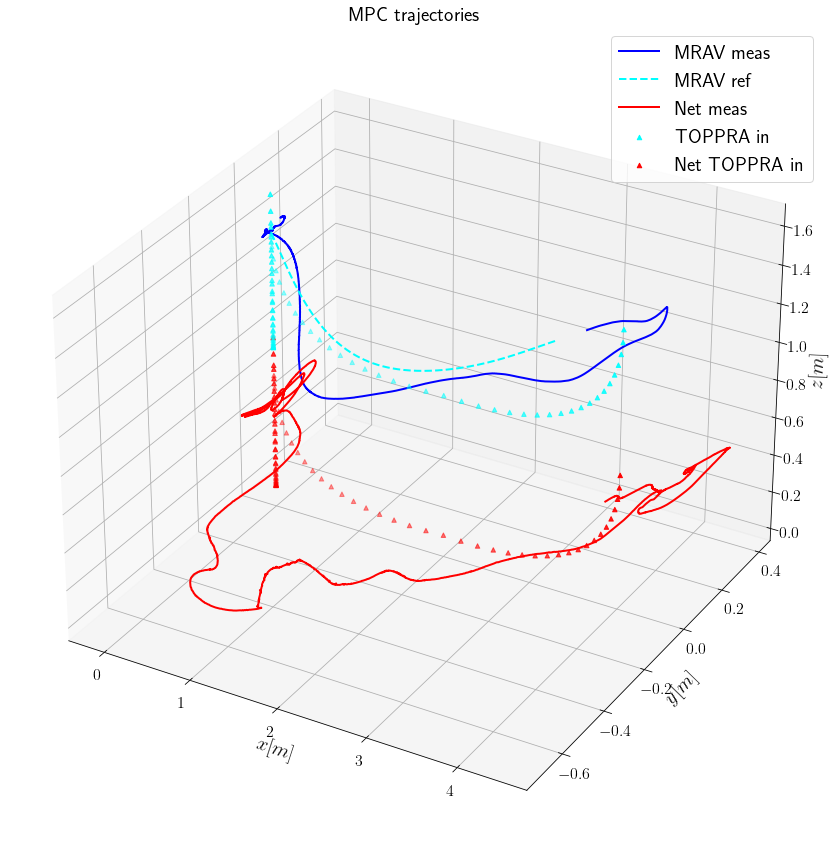

In [50]:
pose_ref = pd.read_csv(csv_[i_carrot])
pose_meas = pd.read_csv(csv_[i_meas])
pose_net = pd.read_csv(csv_[i_net])
vel_ref = pd.read_csv(csv_[i_vel_ref])
input_trajectory = pd.read_csv(csv_[i_tracker])

x_, y_, z_, x_n, y_n, z_n = get_cmd_trajectory(input_trajectory)

#x_ = remove_close_to_zero(x_)
#y_ = remove_close_to_zero(y_)
#z_ = remove_close_to_zero(z_)

start = 90; end=110
pose_ref = scale_time(pose_ref)
pose_ref = crop_df_time(pose_ref, start, end)

#start = 61; end=72
pose_meas = scale_time(pose_meas)
pose_net = scale_time(pose_net)
pose_meas = crop_df_time(pose_meas, start, end)
pose_net = crop_df_time(pose_net, start, end)

t_r,x_r,y_r,z_r = extract_ref(pose_ref, True)
t_m,x_m,y_m,z_m = extract_positions(pose_meas, True)
t_net, x_net, y_net, z_net = extract_positions(pose_net, True)

x_um = (x_m, y_m, z_m)
x_ur = (x_r, y_r, z_r)
x_nm = (x_net, y_net, z_net)
x_tu = (x_, y_, z_)
x_tn = (x_n, y_n, z_n)

plt.rcParams.update({'font.size': 16})   
#plot_vel_pos_bezier(pose_ref, pose_meas, pose_net, 'MPC')
plot_3d_trajectories(x_um, x_ur, x_nm, x_tu, x_tn, label='MPC')

## MPC comparison

In [103]:
i_mpc_toppra_comparison = find_bag_by_name('fastest_pool.bag', bag_paths)
bagreader_mpc_toppra = bagreader(bag_paths[i_mpc_toppra_comparison])
csv_ = create_csv(bagreader_mpc_toppra)

[INFO]  Data folder ./bags/fastest_pool already exists. Not creating.


## MPC test

index: 11; topic_name: ./bags/fastest_pool/red-carrot-pose.csv
index: 3; topic_name: ./bags/fastest_pool/falconsilver-vrpn_client-estimated_odometry.csv
index: 8; topic_name: ./bags/fastest_pool/net-vrpn_client-estimated_odometry.csv
index: 14; topic_name: ./bags/fastest_pool/red-carrot-velocity.csv
index: 50; topic_name: ./bags/fastest_pool/red-tracker-input_trajectory.csv


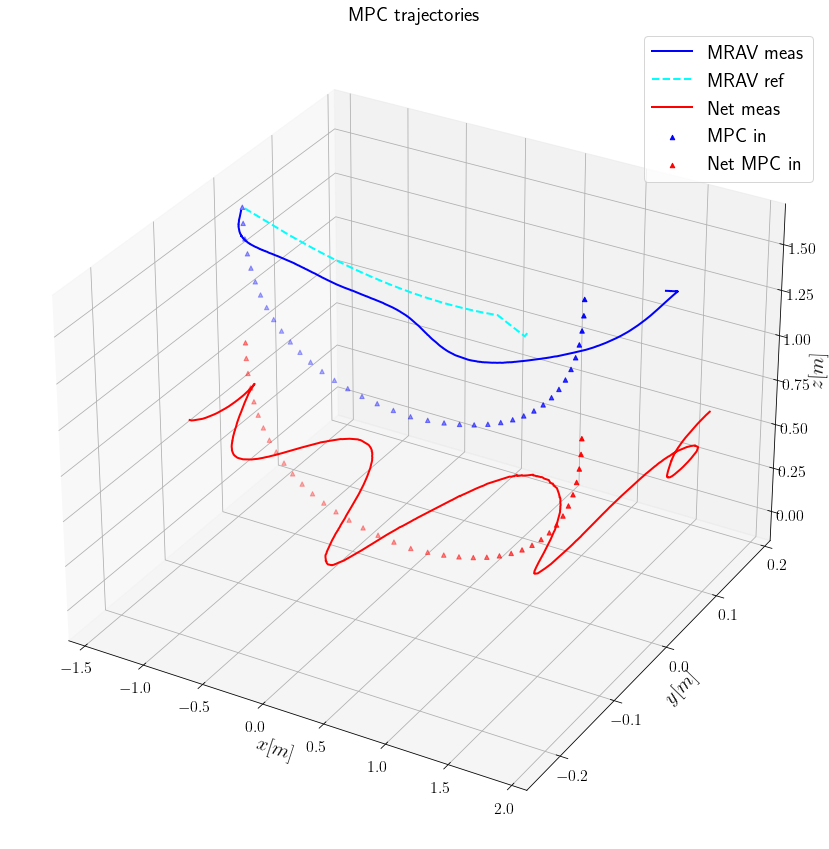

In [107]:
pose_ref, pose_meas, pose_net, vel_ref, input_trajectory = extract_relevant_data(csv_)

#start = 100; end=115
crop = True
if crop:
    start = 37.5; end=43.9; end_ref=47.9
    pose_ref = scale_time(pose_ref)
    pose_meas = scale_time(pose_meas)
    pose_net = scale_time(pose_net)
    pose_ref = crop_df_time(pose_ref, start, end_ref)
    pose_meas = crop_df_time(pose_meas, start, end)
    pose_net = crop_df_time(pose_net, start, end)
    t_r,x_r,y_r,z_r = extract_ref(pose_ref, True)
    t_m,x_m,y_m,z_m = extract_positions(pose_meas, True)
    t_net, x_net, y_net, z_net = extract_positions(pose_net, True)
else: 
    t_r,x_r,y_r,z_r = extract_ref(pose_ref)
    t_m,x_m,y_m,z_m = extract_positions(pose_meas)
    t_net, x_net, y_net, z_net = extract_positions(pose_net)

x_, y_, z_, x_n, y_n, z_n = get_cmd_trajectory(input_trajectory)
#print(x_)

x_um = (x_m, y_m, z_m)
x_ur = (x_r, y_r, z_r)
x_nm = (x_net, y_net, z_net)
x_tu = (x_, y_, z_)
x_tn = (x_n, y_n, z_n)

plt.rcParams.update({'font.size': 16})  
#plot_vel_pos_bezier(pose_ref, pose_meas, pose_net, 'MPC')
plot_3d_trajectories(x_um, x_ur, x_nm, x_tu, x_tn, 'MPC')

## TOPPRA test

#### TODO: 
- [ ] Record TOPPRA/MPC again but with the same constraints and with the same commands 
- [ ] Record position movement and plot object positions with UAV positions 
- [x] Add image of the litter detected in the Netherlands
- [ ] Read and revise 
 


In [100]:
i_fast_toppra = find_bag_by_name('toppra_fast_first.bag', bag_paths)
bagreader_fast_toppra = bagreader(bag_paths[i_fast_toppra])
csv_ = create_csv(bagreader_fast_toppra)
# TODO: Check how to open existing CSV

[INFO]  Successfully created the data folder ./bags/toppra_fast_first.


index: 11; topic_name: ./bags/pose_cmd/red-carrot-pose.csv
index: 3; topic_name: ./bags/pose_cmd/falconsilver-vrpn_client-estimated_odometry.csv
index: 8; topic_name: ./bags/pose_cmd/net-vrpn_client-estimated_odometry.csv
index: 14; topic_name: ./bags/pose_cmd/red-carrot-velocity.csv


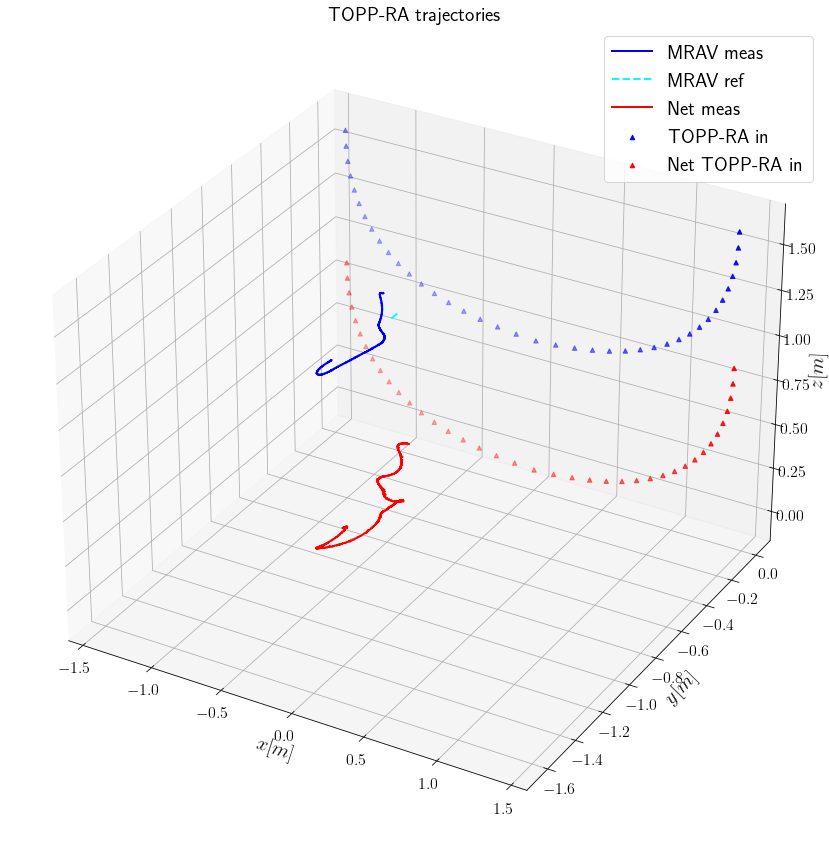

In [116]:
pose_ref, pose_meas, pose_net, vel_ref = extract_relevant_data(csv_)

pose_ref = scale_time(pose_ref)
pose_meas = scale_time(pose_meas)
pose_net = scale_time(pose_net)

crop = True
if crop:
    start = 60; end=66
    pose_ref = crop_df_time(pose_ref, start, end)
    pose_meas = crop_df_time(pose_meas, start, end)
    pose_net = crop_df_time(pose_net, start, end)
    t_r,x_r,y_r,z_r = extract_ref(pose_ref, True)
    t_m,x_m,y_m,z_m = extract_positions(pose_meas, True)
    t_net, x_net, y_net, z_net = extract_positions(pose_net, True)
else: 
    t_r,x_r,y_r,z_r = extract_ref(pose_ref)
    t_m,x_m,y_m,z_m = extract_positions(pose_meas)
    t_net, x_net, y_net, z_net = extract_positions(pose_net)

x_, y_, z_, x_n, y_n, z_n = get_cmd_trajectory(input_trajectory)

x_um = (x_m, y_m, z_m)
x_ur = (x_r, y_r, z_r)
x_nm = (x_net, y_net, z_net)
x_tu = (x_, y_, z_)
x_tn = (x_n, y_n, z_n)
    
#plot_vel_pos_bezier(pose_ref, pose_meas, pose_net, 'TOPP-RA')
plot_3d_trajectories(x_um, x_ur, x_nm, x_tu, x_tn, 'TOPP-RA')

In [120]:
pose_cmd = find_bag_by_name('pose_cmd.bag', bag_paths)
bagreader_pose_cmd = bagreader(bag_paths[pose_cmd])
csv_ = create_csv(bagreader_pose_cmd)
pose_ref, pose_meas, pose_net, vel_ref = extract_relevant_data(csv_)

[INFO]  Data folder ./bags/pose_cmd already exists. Not creating.
index: 11; topic_name: ./bags/pose_cmd/red-carrot-pose.csv
index: 3; topic_name: ./bags/pose_cmd/falconsilver-vrpn_client-estimated_odometry.csv
index: 8; topic_name: ./bags/pose_cmd/net-vrpn_client-estimated_odometry.csv
index: 14; topic_name: ./bags/pose_cmd/red-carrot-velocity.csv


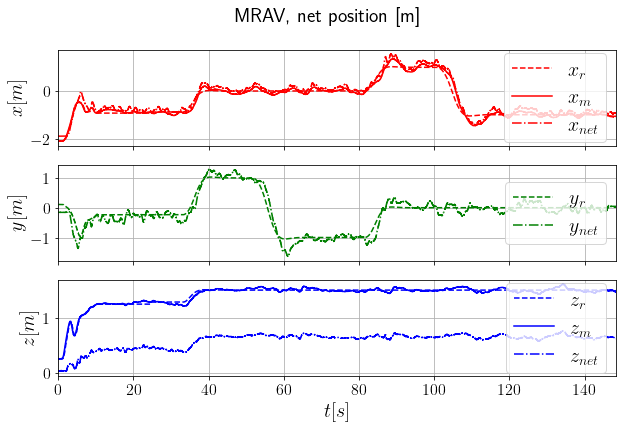

In [134]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 6))

crop = False
if crop:
    start = 60; end=66
    pose_ref = crop_df_time(pose_ref, start, end)
    pose_meas = crop_df_time(pose_meas, start, end)
    pose_net = crop_df_time(pose_net, start, end)
    t_r,x_r,y_r,z_r = extract_ref(pose_ref, True)
    t_m,x_m,y_m,z_m = extract_positions(pose_meas, True)
    t_net, x_net, y_net, z_net = extract_positions(pose_net, True)    
else: 
    t_r,x_r,y_r,z_r = extract_ref(pose_ref)
    t_m,x_m,y_m,z_m = extract_positions(pose_meas)
    t_net, x_net, y_net, z_net = extract_positions(pose_net)

offset = 0
xlim_ = max(t_r)

# Plot object 1 positions
ax1.plot(t_r-offset, x_r, label='$$x_r$$', color='red', linestyle='--')
ax1.plot(t_m, x_m, label='$$x_m$$', color='red')
ax1.plot(t_net, x_net, label='$$x_{net}$$', color='red', linestyle='-.')
ax1.set_ylabel('$$x [m]$$', fontsize=label_size)
ax1.grid()
ax1.set_xlim(0, xlim_)
ax1.legend(fontsize=label_size, loc='center right')

# Plot object 2 positions
ax2.plot(t_r-offset, y_r, label='$$y_r$$', color='green', linestyle='--')
#ax2.plot(y_m, y_m, label='$$y_m$$', color='green')
ax2.plot(t_net, y_net, label='$$y_{net}$$', color='green', linestyle='-.')
ax2.set_ylabel('$$y [m]$$', fontsize=label_size)
ax2.grid()
ax2.set_xlim(0, xlim_)
ax2.legend(fontsize=label_size, loc='center right')

# Plot object 2 positions
ax3.plot(t_r-offset, z_r, label='$$z_r$$', color='blue', linestyle='--')
ax3.plot(t_m, z_m, label='$$z_m$$', color='blue')
ax3.plot(t_net, z_net, label='$$z_{net}$$', color='blue', linestyle='-.')
ax3.set_ylabel('$$z [m]$$', fontsize=label_size)
ax3.set_xlabel('$$t [s]$$', fontsize=label_size)
ax3.grid()
ax3.legend(fontsize=label_size, loc='center right')
plt.suptitle('MRAV, net position [m]', fontsize=label_size)
plt.savefig('PosTest.svg')

In [110]:
def extract_relevant_data(csv): 
    
    i_carrot = find_topic_name_and_index('carrot-pose', csv_)
    i_meas = find_topic_name_and_index('falconsilver-vrpn', csv_)
    i_net = find_topic_name_and_index('net-vrpn', csv_)
    i_vel_ref = find_topic_name_and_index('carrot-velocity', csv_)
    #i_tracker = find_topic_name_and_index('input_trajectory', csv_)
    #i_detected_objects = find_topic_name_and_index('detected_objects', csv_)

    pose_ref = pd.read_csv(csv_[i_carrot])
    pose_meas = pd.read_csv(csv_[i_meas])
    pose_net = pd.read_csv(csv_[i_net])
    vel_ref = pd.read_csv(csv_[i_vel_ref])
    #input_trajectory = pd.read_csv(csv_[i_tracker])
    #detected_poses = pd.read_csv(csv_[i_detected_objects])
    
    return pose_ref, pose_meas, pose_net, vel_ref#, input_trajectory

In [96]:
def plot_vel_pos_bezier(pose_ref, pose_meas, pose_net, label): 
    
    vt_m,vx_m, vy_m, vz_m = extract_velocities(pose_meas)
    t_r,x_r,y_r,z_r = extract_ref(pose_ref)
    t_m,x_m,y_m,z_m = extract_positions(pose_meas)
    t_net, x_net, y_net, z_net = extract_positions(pose_net)
    pose_meas = scale_time(pose_meas)
    vt_r,vx_r, vy_r, vz_r = pose_meas['Time'], pose_meas['twist.twist.linear.x'], pose_meas['twist.twist.linear.y'], pose_meas['twist.twist.linear.z']
    
    # Figure 
    label_size=20
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex=True, figsize=(10, 8))

    offset = 0
    xlim_ = max(t_r)

    # Plot object 1 positions
    ax1.plot(t_r-offset, x_r, label='$$x_r$$', color='red')
    ax1.plot(t_m, x_m, label='$$x_m$$', color='red', linestyle='--')
    ax1.set_ylabel('$$x [m]$$', fontsize=label_size)
    ax1.grid()
    ax1.set_xlim(0, xlim_)
    ax1.legend(fontsize=label_size)

    # Plot object 2 positions
    ax2.plot(vt_r, vy_r, label='$$vx_r$$', color='red')
    ax2.plot(vt_m, vy_m, label='$$vx_m$$', color='red', linestyle='--')
    ax2.set_ylabel('$$vx [m/s]$$', fontsize=label_size)
    ax2.grid()
    ax2.set_xlim(0, xlim_)
    ax2.legend(fontsize=label_size, loc='center left')

    # Plot object 2 positions
    ax3.plot(t_r-offset, y_r, label='$$y_r$$', color='blue')
    ax3.plot(t_m, y_m, label='$$y_m$$', color='blue', linestyle='--')
    ax3.set_ylabel('$$y [m]$$', fontsize=label_size)
    ax3.grid()
    ax3.legend(fontsize=label_size, loc='center left')

    # Plot object 2 velocities
    ax4.plot(vt_r, vz_r, label='$$vy_r$$', color='blue')
    ax4.plot(vt_m, vz_m, label='$$vy_m$$', color='blue', linestyle='--')
    ax4.set_ylabel('$$vy [m/s]$$', fontsize=label_size)
    ax4.grid()
    ax4.set_xlim(0, xlim_)
    ax4.legend(fontsize=label_size, loc='center right')

    # Plot object 2 positions
    ax5.plot(t_r-offset, z_r, label='$$z_r$$', color='green')
    ax5.plot(t_m, z_m, label='$$z_m$$', color='green', linestyle='--')
    ax5.set_ylabel('$$z [m]$$', fontsize=label_size)
    ax5.grid()
    ax5.set_xlim(0, xlim_)
    ax5.legend(fontsize=label_size, loc='center right')

    # Plot object 2 positions
    ax6.plot(vt_r, vz_r, label='$$vz_r$$', color='green')
    ax6.plot(vt_m, vz_m, label='$$vz_m$$', color='green', linestyle='--')
    ax6.set_ylabel('$$vz [m/s]$$', fontsize=label_size)
    ax6.grid()
    ax6.set_xlim(0, xlim_)
    ax6.legend(fontsize=label_size, loc='center right')
    ax6.set_xlabel('$$t [s]$$', fontsize=label_size)
    
    plt.suptitle('{} tracker positions [m], velocities [m/s]'.format(label), fontsize=label_size)
    plt.savefig('{}PosVel.svg'.format(label))
    
def plot_3d_trajectories(x_um, x_ur, x_nm, x_tu, x_tn, label):
    """
    Plots two 3D trajectories and scatter points given their x, y, and z coordinates.

    Args:
        x1, y1, z1: Lists of x, y, and z coordinates for the first trajectory.
        x2, y2, z2: Lists of x, y, and z coordinates for the second trajectory.
        x0, y0, z0: Lists of x, y, and z coordinates for the scatter points.
    """
    label_size=20
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    
    # TODO: Think of better labels!
    # Plot the UAV trajectory
    ax.plot(x_um[0], x_um[1], x_um[2], label='MRAV meas', color='blue', linewidth=2)
    ax.plot(x_ur[0], x_ur[1], x_ur[2], label='MRAV ref', color='cyan', linestyle='--', linewidth=2)

    # Plot the net trajectory
    ax.plot(x_nm[0], x_nm[1], x_nm[2], label='Net meas', color='red', linewidth=2)

    # Scatter plot for additional points
    ax.scatter(x_tu[0], x_tu[1], x_tu[2], label='{} in'.format(label), color='blue', marker='^')
    ax.scatter(x_tn[0], x_tn[1], x_tn[2], label='Net {} in'.format(label), color='red', marker='^')

    # Set labels for the axes
    ax.set_xlabel('$$x [m]$$', fontsize=label_size)
    ax.set_ylabel('$$y [m]$$', fontsize=label_size)
    ax.set_zlabel('$$z [m]$$', fontsize=label_size)

    # Add a legend
    ax.legend(fontsize=label_size)
    
    plt.title('{} trajectories'.format(label), fontsize=label_size)
    fig.savefig('{}3DTrajectories.svg'.format(label))

    # Show the 3D plot
    plt.show()
    
def extract_numbers(string_list):
    # Use a list comprehension to extract the numbers from each string
    numbers = [eval(s.split(': ')[1]) for s in string_list if ': ' in s]
    return numbers

def remove_close_to_zero(input_list, threshold=0.001):
    # Use a list comprehension to create a new list without numbers close to zero
    result_list = [x for x in input_list if abs(x) > threshold]
    return result_list

def get_cmd_trajectory(input_trajectory):
    trajectory = input_trajectory['points'].values

    # Find a word that we can use
    a = str(trajectory).split('translation')
    x, y, z = [], [], []
    for i, value in enumerate(a):
        if i > 0:
            _ = value.split("\\n")
            x.append(_[1])
            y.append(_[2])
            z.append(_[3])

    # Trajectory command UAV
    x_ = extract_numbers(x)
    y_ = extract_numbers(y)
    z_ = extract_numbers(z)

    # Trajectory command Net
    net_offset = 0.75
    x_n = x_; y_n = y_; z_n = [z - net_offset for z in z_]
    
    return x_, y_, z_, x_n, y_n, z_n

# TODO: 
- [x] Plot UAV and the NET position 
- [x] Plot relative position
- [x] Plot net orientation
- [x] Increase fonts and legends
- [x] Plot Bezier for starters and check pool 
- [x] Crop method based on the time 
- [ ] Plot UAV and the NET position for the multiple times   

## Findings: 
- [x] When optitrack loses markers, we lose measurements (more optitrack markers)
- [x] Optitrack markers on a can (to record even relative position between net and the object) --> doesn't work


In [58]:
print(bag_paths)

['./bags/toppra_test_dunking.bag', './bags/compressed_img_stationary.bag', './bags/bezier_first_try', './bags/toppra_long_dunking', './bags/pose_cmd', './bags/bezier_first_try.bag', './bags/toppra_dunk_first.bag', './bags/first_fast_pool', './bags/first_fast_pool.bag', './bags/pose_cmd.bag', './bags/toppra_fast_first', './bags/second_fly_test.bag', './bags/toppra_weighted_net_first', './bags/toppra_dunk_third.bag', './bags/bags_2023-09-07-15-34-23.bag', './bags/toppra_weighted_net_first.bag', './bags/catch_try', './bags/first_fly_test.bag', './bags/bezier_full_slow.bag', './bags/fastest_pool.bag', './bags/toppra_fast_first.bag', './bags/second_try_pool.bag', './bags/mpc_toppra_compr.bag', './bags/catch_try.bag', './bags/new_bags', './bags/toppra_dunk_second', './bags/bezier_full_slow', './bags/toppra_long_dunking.bag', './bags/bezier_full_fast.bag', './bags/fourth_try_test.bag', './bags/toppra_first.bag', './bags/bezier_full_fast', './bags/third_fly_test.bag', './bags/mpc_toppra_compr'

In [145]:
new_bag_paths = []
for bag_name in os.listdir("./bags/new_bags/"):
    new_bag_paths.append("./bags/new_bags/{}".format(bag_name))

In [158]:
detections = find_bag_by_name('_2023-09-15-18-19-46.bag', new_bag_paths)
bagreader_detections = bagreader(new_bag_paths[detections])
csv_ = create_csv(bagreader_detections)
pose_ref, pose_meas, pose_net, vel_ref = extract_relevant_data(csv_)

[INFO]  Data folder ./bags/new_bags/_2023-09-15-18-19-46 already exists. Not creating.
index: 11; topic_name: ./bags/new_bags/_2023-09-15-18-19-46/red-carrot-pose.csv
index: 3; topic_name: ./bags/new_bags/_2023-09-15-18-19-46/falconsilver-vrpn_client-estimated_odometry.csv
index: 8; topic_name: ./bags/new_bags/_2023-09-15-18-19-46/net-vrpn_client-estimated_odometry.csv
index: 14; topic_name: ./bags/new_bags/_2023-09-15-18-19-46/red-carrot-velocity.csv


In [354]:
i_detected_poses =  find_topic_name_and_index('detected_poses', csv_)
detected_poses = pd.read_csv(csv_[i_detected_poses])

index: 1; topic_name: ./bags/new_bags/_2023-09-15-18-19-46/detected_poses.csv


In [355]:
t = detected_poses['Time']
poses = detected_poses['poses']

In [402]:
def parse_poses_into_dict(poses, limit):
    poses_dct = {}
    cnt = 0
    for k, pose_ in enumerate(poses[:limit]): 
        p = pose_.split('pose')
        for i in p:
            a = i.split('\n')
            if len(a) > 1: 
                x = eval(a[1].split(":")[1])
                y = eval(a[2].split(":")[1])
                z = eval(a[3].split(":")[1])
                if "]" in a[4]:
                    id_ = eval(a[4].split(":")[1].replace("]", ""))
                else: 
                    id_ = eval(a[4].split(":")[1].replace(",", ""))
            else: 
                continue
            if str(id_) in poses_dct.keys():

                poses_dct["{}".format(id_)].append((x, y, z, k))
            else: 
                poses_dct["{}".format(id_)] = [(x, y, z, k)]
    return poses_dct

            
def parse_dict_element(element): 
    kt, t, p = [], [], []
    for i, e in enumerate(element):
        kt = e[3]
        t.append(i)
        if abs(e[0]) < 5 and abs(e[1]) < 5 and abs(e[2]) < 5:
            p.append(np.array([e[0], e[1], e[2]]))
        else:
            p.append(np.array([0, 0, 0]))
    return kt, t, p

import random
    
def random_color_hex():
    # Generate random RGB values
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)

    # Convert RGB to hexadecimal
    hex_color = "#{:02x}{:02x}{:02x}".format(r, g, b)
    
    return hex_color

def plot_tracked_detection(kt, t, p, axes, id_): 
    
    c = random_color_hex()
    
    px = [p_[0] for p_ in p]
    py = [p_[1] for p_ in p]
    pz = [p_[2] for p_ in p]
    
    axs[0, 1].scatter([(kt + t_)*1/30 for t_ in t], px, label="${}$".format(id_), color=c)
    axs[0, 1].scatter([t_*1/7 for t_ in t], px, label="${}$".format(id_), color=c)
    axs[0, 1].grid()
    axs[1, 1].scatter([(kt + t_)*1/30 for t_ in t], py, label="${}$".format(id_), color=c)
    axs[1, 1].scatter([t_*1/7 for t_ in t], px, label="${}$".format(id_), color=c)
    axs[1, 1].grid()
    axs[2, 1].scatter([(kt + t_)*1/30 for t_ in t], pz, label="${}$".format(id_), color=c)
    #axs[2].scatter([t_*1/7 for t_ in t], px, label="${}$".format(id_), color=c)
    axs[2, 1].grid()
    #axs[2].legend()

In [403]:
print(poses)
poses_dct = parse_poses_into_dict(poses, 10000)

0       [pose: \n  x: 0.30073467300719453\n  y: 0.4618...
1       [pose: \n  x: 0.2979775708770443\n  y: 0.45761...
2       [pose: \n  x: -366.02540378443837\n  y: -1000....
3       [pose: \n  x: -366.02540378443837\n  y: -1000....
4       [pose: \n  x: -366.02540378443837\n  y: -1000....
                              ...                        
3512    [pose: \n  x: -366.02540378443837\n  y: -1000....
3513    [pose: \n  x: 1.217800851222151\n  y: 0.755153...
3514    [pose: \n  x: 1.216448063106793\n  y: 0.748987...
3515    [pose: \n  x: 1.218419464555047\n  y: 0.758388...
3516    [pose: \n  x: 1.1956634917120652\n  y: 0.74422...
Name: poses, Length: 3517, dtype: object


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


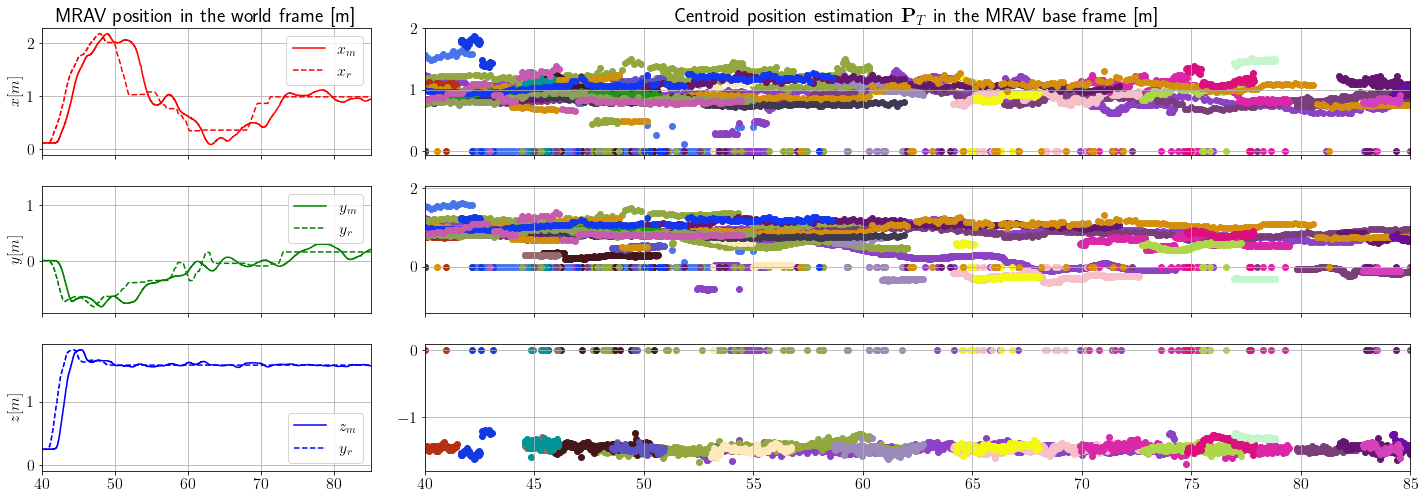

In [443]:
kt, t, p = parse_dict_element(poses_dct['0'])
kt1, t1, p1 = parse_dict_element(poses_dct['1'])
kt2, t2, p2 = parse_dict_element(poses_dct['2'])

kt, t, p = [], [], []

for i in poses_dct.keys():
    print(i)
    kt_, t_, p_ = parse_dict_element(poses_dct[i])
    kt.append(kt_); t.append(t_); p.append(p_)

plt.rcParams.update({'font.size': 16})  
fig, axs = plt.subplots(3, 2, figsize=(20,7), sharex='col', gridspec_kw={'width_ratios': [1, 3]})
fig.tight_layout()
    
cnt = 0
for ktt, tt, pp in zip(kt, t, p): 
    plot_tracked_detection(ktt, tt, pp, axs, cnt)
    cnt += 1
    
axs[0, 0].set_ylabel('$x [m]$')
axs[1, 0].set_ylabel('$y [m]$')
axs[2, 0].set_ylabel('$z [m]$')
axs[0, 0].set_title('MRAV position in the world frame [m]', fontsize=20)
axs[0, 1].set_title('Centroid position estimation $\mathbf{P}_{T}$ in the MRAV base frame [m]', fontsize=20)


t_r,x_r,y_r,z_r = extract_ref(pose_ref)
t_m,x_m,y_m,z_m = extract_positions(pose_meas)

ref_off = -6
axs[0, 0].plot(t_m, x_m, color='red', label='$x_m$'); 
axs[0, 0].plot(t_r+ref_off, x_r, color='red', label='$x_r$', linestyle='--');
axs[0, 0].grid()
axs[0, 0].legend()

axs[1, 0].plot(t_m, y_m, color='green', label='$y_m$');
axs[1, 0].plot(t_r+ref_off, y_r, color='green', label='$y_r$', linestyle='--');
axs[1, 0].grid()
axs[1, 0].legend()

axs[2, 0].plot(t_m, z_m, color='blue', label='$z_m$');
axs[2, 0].plot(t_r+ref_off, z_r, color='blue', label='$y_r$', linestyle='--'); 
axs[2, 0].grid()
axs[2, 0].legend()

axs[1, 0].set_xlim(40, 85)
axs[0, 1].set_xlim(40, 85)
axs[0, 1].set_ylim(-0.05, 2)

fig.savefig('CentroidTracking.svg')

In [389]:
print(poses_dct)


{'0': [(0.30073467300719453, 0.4618447422981262, -1.4637362368357032, 0), (0.2979775708770443, 0.4576106369495392, -1.4503169302792993, 1), (-366.02540378443837, -1000.0, -1366.0254037844386, 2), (-366.02540378443837, -1000.0, -1366.0254037844386, 3), (-366.02540378443837, -1000.0, -1366.0254037844386, 4), (-366.02540378443837, -1000.0, -1366.0254037844386, 5), (0.29776547905574985, 0.45728492736816406, -1.4492846270518334, 6), (0.29352380975219966, 0.45077091455459595, -1.4286395672226313, 7), (-366.02540378443837, -1000.0, -1366.0254037844386, 8), (0.28291966230289256, 0.4344858229160309, -1.377026902748465, 9), (0.2907667076220495, 0.4465367794036865, -1.4152202606662276, 10), (0.2924634182358804, 0.4491423964500427, -1.4234782873641696, 11), (0.2801625601727423, 0.43025171756744385, -1.3636075961920613, 12), (0.28313169451954223, 0.4348115026950836, -1.3780591027376579, 13), (0.28419211184542975, 0.43644002079963684, -1.3832203676949584, 14), (0.27846587536847967, 0.427646100521087